In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [2]:
import os
os.chdir('/home/lyz/co-phase-separation/PSGAT/')
DATA_ROOT = './data'

In [3]:
SAVE_ROOT = './saves/INTEGRATE_ProSE80d_pos1neg1/'
preds = pd.read_pickle(f'{SAVE_ROOT}preds.pkl')
genes = pd.read_pickle(f'{SAVE_ROOT}genes.pkl')

N = 10

In [4]:
phasep_df = pd.read_pickle('./data/Label/human.condensate-formation.proteins-v1.pkl')
lt = set(phasep_df[phasep_df['source']=='literature']['uniprot_entry'])
pr = set(phasep_df[phasep_df['source']=='phasepred']['uniprot_entry'])
pr = pr - lt
dp = set(phasep_df[phasep_df['source']=='deepphase']['uniprot_entry'])
dp = dp - pr - lt

# Classification of PS-PPI vs. PS-Random, PS-PPI vs. nonPS-PPI

In [5]:
ppi = 'integrate'

## PS-PPI and nonPS-PPI

In [6]:
ppi_path = os.path.join(
    DATA_ROOT,           
    f'PPIN/{ppi.upper()}.csv'
)
edges = pd.read_csv(ppi_path)
edges['C'] = np.sort(edges[['A', 'B']].values).sum(axis=1)

for i in range(N): 
    tmp = pd.read_pickle(f'{SAVE_ROOT}edge_cosine/model_{i}.pkl')
    edges[i] = tmp['cosim']
edges['pred'] = edges.iloc[:, 3:].mean(axis=1)

edges.loc[(edges['A'].isin(lt))&(edges['B'].isin(lt)), 'type'] = 'ps.ppi'
edges['type'] = edges['type'].fillna('nps.ppi')

## PS-PPI and PS-Rand

In [7]:
from itertools import combinations
lt_ppin = set(genes) & lt
comb = pd.DataFrame([i for i in combinations(lt_ppin, 2)])
comb.columns = ['A', 'B']
comb['C'] = np.sort(comb[['A', 'B']].values).sum(axis=1)

In [34]:
comb

,A,B,C,0,1,2,3,4,5,6,7,8,9,pred,type
0,P36873,Q9BY44,P36873Q9BY44,0.541926,0.559519,0.567451,0.536653,0.490558,0.468227,0.550221,0.582149,0.445279,0.422465,0.516445,ps.rand
1,P36873,P27694,P27694P36873,0.557765,0.388691,0.408954,0.718757,0.206310,0.614957,0.474308,0.490712,0.335560,0.540767,0.473678,ps.rand
2,P36873,P54274,P36873P54274,0.217648,0.322477,0.634737,0.606659,0.504600,0.480063,0.662097,0.539022,0.254149,0.341229,0.456268,ps.rand
3,P36873,O60936,O60936P36873,0.576525,0.467110,0.602120,0.301759,0.485729,0.420821,0.610238,0.367862,0.350257,0.630316,0.481274,ps.rand
4,P36873,P15056,P15056P36873,0.556889,0.392732,0.628280,0.599430,0.257501,0.253649,0.573787,0.271925,0.473428,0.460434,0.446805,ps.rand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240466,Q99848,Q9NWB1,Q99848Q9NWB1,0.717689,0.610190,0.554450,0.591474,0.639234,0.154552,0.636944,0.290041,0.602669,0.666603,0.546385,ps.rand
240467,Q99848,Q96JC9,Q96JC9Q99848,0.564989,0.511144,0.647357,0.706797,0.586223,0.470720,0.664548,0.582227,0.735436,0.663739,0.613318,ps.rand
240468,Q6ZN04,Q9NWB1,Q6ZN04Q9NWB1,0.491606,0.496301,0.361197,0.565282,0.620293,0.349553,0.552073,0.548185,0.608952,0.344982,0.493842,ps.rand
240469,Q6ZN04,Q96JC9,Q6ZN04Q96JC9,0.320793,0.381537,0.247437,0.525675,0.623691,0.206897,0.583109,0.464425,0.583260,0.262561,0.419939,ps.rand


In [8]:
from tqdm import tqdm
for n in tqdm(range(N)):
    pairwise_cosim = pd.read_pickle(f'{SAVE_ROOT}pairwise_cosine/model_{n}.pkl')
    hh = list()
    for _, i in comb.iterrows():
        a, b = i['A'], i['B']
        s = pairwise_cosim[a][b]
        hh.append(s)
    comb[n] = hh
    comb.loc[comb[n] < 0, n] = 0
    comb.loc[comb[n] > 1, n] = 1

100%|██████████| 10/10 [01:54<00:00, 11.46s/it]


In [9]:
comb['pred'] = comb.iloc[:, 3:].mean(axis=1)
comb.loc[comb['C'].isin(edges['C']), 'type'] = 'ps.ppi'
comb['type'] = comb['type'].fillna('ps.rand')

## nonPS-Rand

In [10]:
from itertools import combinations
from random import sample, seed
nc_ppin = set(genes) - lt
seed(1234)
nc_ppin_samples = sample(nc_ppin, len(lt_ppin) * 3) # random selection of non-PS proteins

comb2 = pd.DataFrame([i for i in combinations(nc_ppin_samples, 2)])
comb2.columns = ['A', 'B']
comb2['C'] = np.sort(comb2[['A', 'B']].values).sum(axis=1)

# random selection from negative samples (pos: neg = 1: 3)
comb3 = comb2[~comb2['C'].isin(edges['C'])]\
            .sample(n=3 * edges[edges['type']=='nps.ppi'].shape[0], random_state=1234).reset_index(drop=True)

In [11]:
from tqdm import tqdm
for n in tqdm(range(N)):
    pairwise_cosim = pd.read_pickle(f'{SAVE_ROOT}pairwise_cosine/model_{n}.pkl')
    hh = list()
    for _, i in comb3.iterrows():
        a, b = i['A'], i['B']
        s = pairwise_cosim[a][b]
        hh.append(s)
    comb3[n] = hh
    comb3.loc[comb3[n] < 0, n] = 0
    comb3.loc[comb3[n] > 1, n] = 1

100%|██████████| 10/10 [05:26<00:00, 32.61s/it]


In [12]:
comb3['pred'] = comb3.iloc[:, 3:].mean(axis=1)
comb3['type'] = 'nps.rand'

## Merge, adding other features

In [13]:
dat = pd.concat([edges, comb[comb['type']=='ps.rand'], comb3])[['A', 'B', 'C', 'pred', 'type']].reset_index(drop=True)

In [14]:
dat['type'].value_counts()

nps.rand    715686
nps.ppi     238562
ps.rand     237569
ps.ppi        2902
Name: type, dtype: int64

In [15]:
dat.groupby('type')['pred'].median()

type
nps.ppi     0.539520
nps.rand    0.289146
ps.ppi      0.700719
ps.rand     0.508526
Name: pred, dtype: float32

In [16]:
feat = pd.read_csv('./data/NodeFeat/human_rnk_0210.csv')
feat_cols = [
    'hydropathy', 'FCR', 'catGRANULE', 'Pscore', 'PLAAC', 
    'espritz disprot', 'LCD', 'deepcoil', 'IF', 'phos freq', 
    'SaPS-8fea', 'PdPS-8fea', 'SaPS-10fea', 'PdPS-10fea'
]

for c in feat_cols:
    feat_dict = feat.set_index('Entry').to_dict()[c]
    dat[f'A.{c}'] = dat['A'].map(feat_dict)
    dat[f'B.{c}'] = dat['B'].map(feat_dict)
    dat[c] = (dat[f'A.{c}'] + dat[f'B.{c}']) / 2
    dat = dat.drop(columns=[f'A.{c}', f'B.{c}'])

In [17]:
dat.head()

,A,B,C,pred,type,hydropathy,FCR,catGRANULE,Pscore,PLAAC,espritz disprot,LCD,deepcoil,IF,phos freq,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea
0,Q9H2S6,Q9NPE6,Q9H2S6Q9NPE6,0.825629,nps.ppi,0.454167,0.241065,0.232927,1.915,-0.3215,0.070938,0.189570,0.0,NaN,0.003155,0.180668,0.333708,0.057492,0.202955
1,Q9H2S6,Q9BXK5,Q9BXK5Q9H2S6,0.779457,nps.ppi,0.459711,0.257904,-0.114610,1.000,-0.3765,0.006186,0.183050,0.0,NaN,0.029959,0.151175,0.245383,0.231277,0.328275
2,Q9H2S6,O60238,O60238Q9H2S6,0.482954,nps.ppi,0.434301,0.249968,0.436083,1.445,-0.2260,0.191781,0.219005,0.0,NaN,0.041967,0.349152,0.369417,0.475005,0.611476
3,Q9H2S6,P20138,P20138Q9H2S6,0.555613,nps.ppi,0.457043,0.229664,0.132726,1.000,-0.3420,0.057692,0.130096,0.0,NaN,0.015517,0.152326,0.247318,0.067165,0.205647
4,Q9H2S6,Q9UM44,Q9H2S6Q9UM44,0.402981,nps.ppi,0.461800,0.233374,0.032132,0.395,-0.3250,0.031401,0.098927,0.0,NaN,0.003155,0.149815,0.246193,0.058897,0.191480


In [24]:
dat.to_pickle(f'{SAVE_ROOT}04-edge_classification.pkl')

## AUC calculation

In [5]:
dat = pd.read_pickle(f'{SAVE_ROOT}04-edge_classification.pkl')

In [11]:
dat = dat.rename(columns={'Pscore': 'PScore'})

In [12]:
dat.columns

Index(['A', 'B', 'C', 'pred', 'type', 'hydropathy', 'FCR', 'catGRANULE',
       'PScore', 'PLAAC', 'espritz disprot', 'LCD', 'deepcoil', 'IF',
       'phos freq', 'SaPS-8fea', 'PdPS-8fea', 'SaPS-10fea', 'PdPS-10fea'],
      dtype='object')

### score_dict1: PS-PPI vs. PS-Random

In [13]:
from collections import defaultdict
score_dict1 = defaultdict()
types = ['ps.ppi', 'ps.rand']
score_cols = [
    'pred', 'hydropathy', 'FCR', 'catGRANULE',
    'PScore', 'PLAAC', 'espritz disprot', 'LCD', 
    'deepcoil', 'IF', 'phos freq', 'SaPS-8fea', 
    'PdPS-8fea', 'SaPS-10fea', 'PdPS-10fea'
]

for s in tqdm(score_cols):
    df = dat[(dat[s].notna())&(dat['type'].isin(types))].sort_values(by=['type']).reset_index(drop=True)
    probs, y_test = df[s].to_numpy(), df['type'].to_numpy()
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    if s in ['hydropathy', 'PLAAC', 'deepcoil']:
        fpr, tpr, _ = roc_curve(y_onehot_test[:, ], probs[:, ], pos_label=1)
    else:
        fpr, tpr, _ = roc_curve(y_onehot_test[:, ], probs[:, ], pos_label=0)
    roc_auc = auc(fpr, tpr)
    score_dict1[s] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }

100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


### score_dict2: PS-PPI vs. nonPS-PPI

In [14]:
from collections import defaultdict
score_dict2 = defaultdict()
types = ['ps.ppi', 'nps.ppi']
score_cols = [
    'pred', 'hydropathy', 'FCR', 'catGRANULE',
    'PScore', 'PLAAC', 'espritz disprot', 'LCD', 
    'deepcoil', 'IF', 'phos freq', 'SaPS-8fea', 
    'PdPS-8fea', 'SaPS-10fea', 'PdPS-10fea'
]

for s in tqdm(score_cols):
    df = dat[(dat[s].notna())&(dat['type'].isin(types))].sort_values(by=['type']).reset_index(drop=True)
    probs, y_test = df[s].to_numpy(), df['type'].to_numpy()
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    if s in ['hydropathy', 'deepcoil']:
        fpr, tpr, _ = roc_curve(y_onehot_test[:, ], probs[:, ], pos_label=0)
    else:
        fpr, tpr, _ = roc_curve(y_onehot_test[:, ], probs[:, ], pos_label=1)
    roc_auc = auc(fpr, tpr)
    score_dict2[s] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }

100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


In [30]:
df1 = pd.DataFrame(score_dict1).T.drop(columns=['fpr', 'tpr']).reset_index()
df1.columns = ['predictor', 'ps-ppi vs. ps-rand']
temp_dict = pd.DataFrame(score_dict2).T.drop(columns=['fpr', 'tpr']).to_dict()['auc']
df1['ps-ppi vs. nps-ppi'] = df1['predictor'].map(temp_dict)
df1

,predictor,ps-ppi vs. ps-rand,ps-ppi vs. nps-ppi
0,pred,0.849176,0.788937
1,hydropathy,0.583082,0.764796
2,FCR,0.627888,0.702287
3,catGRANULE,0.603414,0.785741
4,PScore,0.509974,0.701106
5,PLAAC,0.532215,0.644682
6,espritz disprot,0.578313,0.692881
7,LCD,0.568289,0.696457
8,deepcoil,0.515764,0.519897
9,IF,0.602338,0.679967


## Visualization

In [15]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

### ROC curve

[]

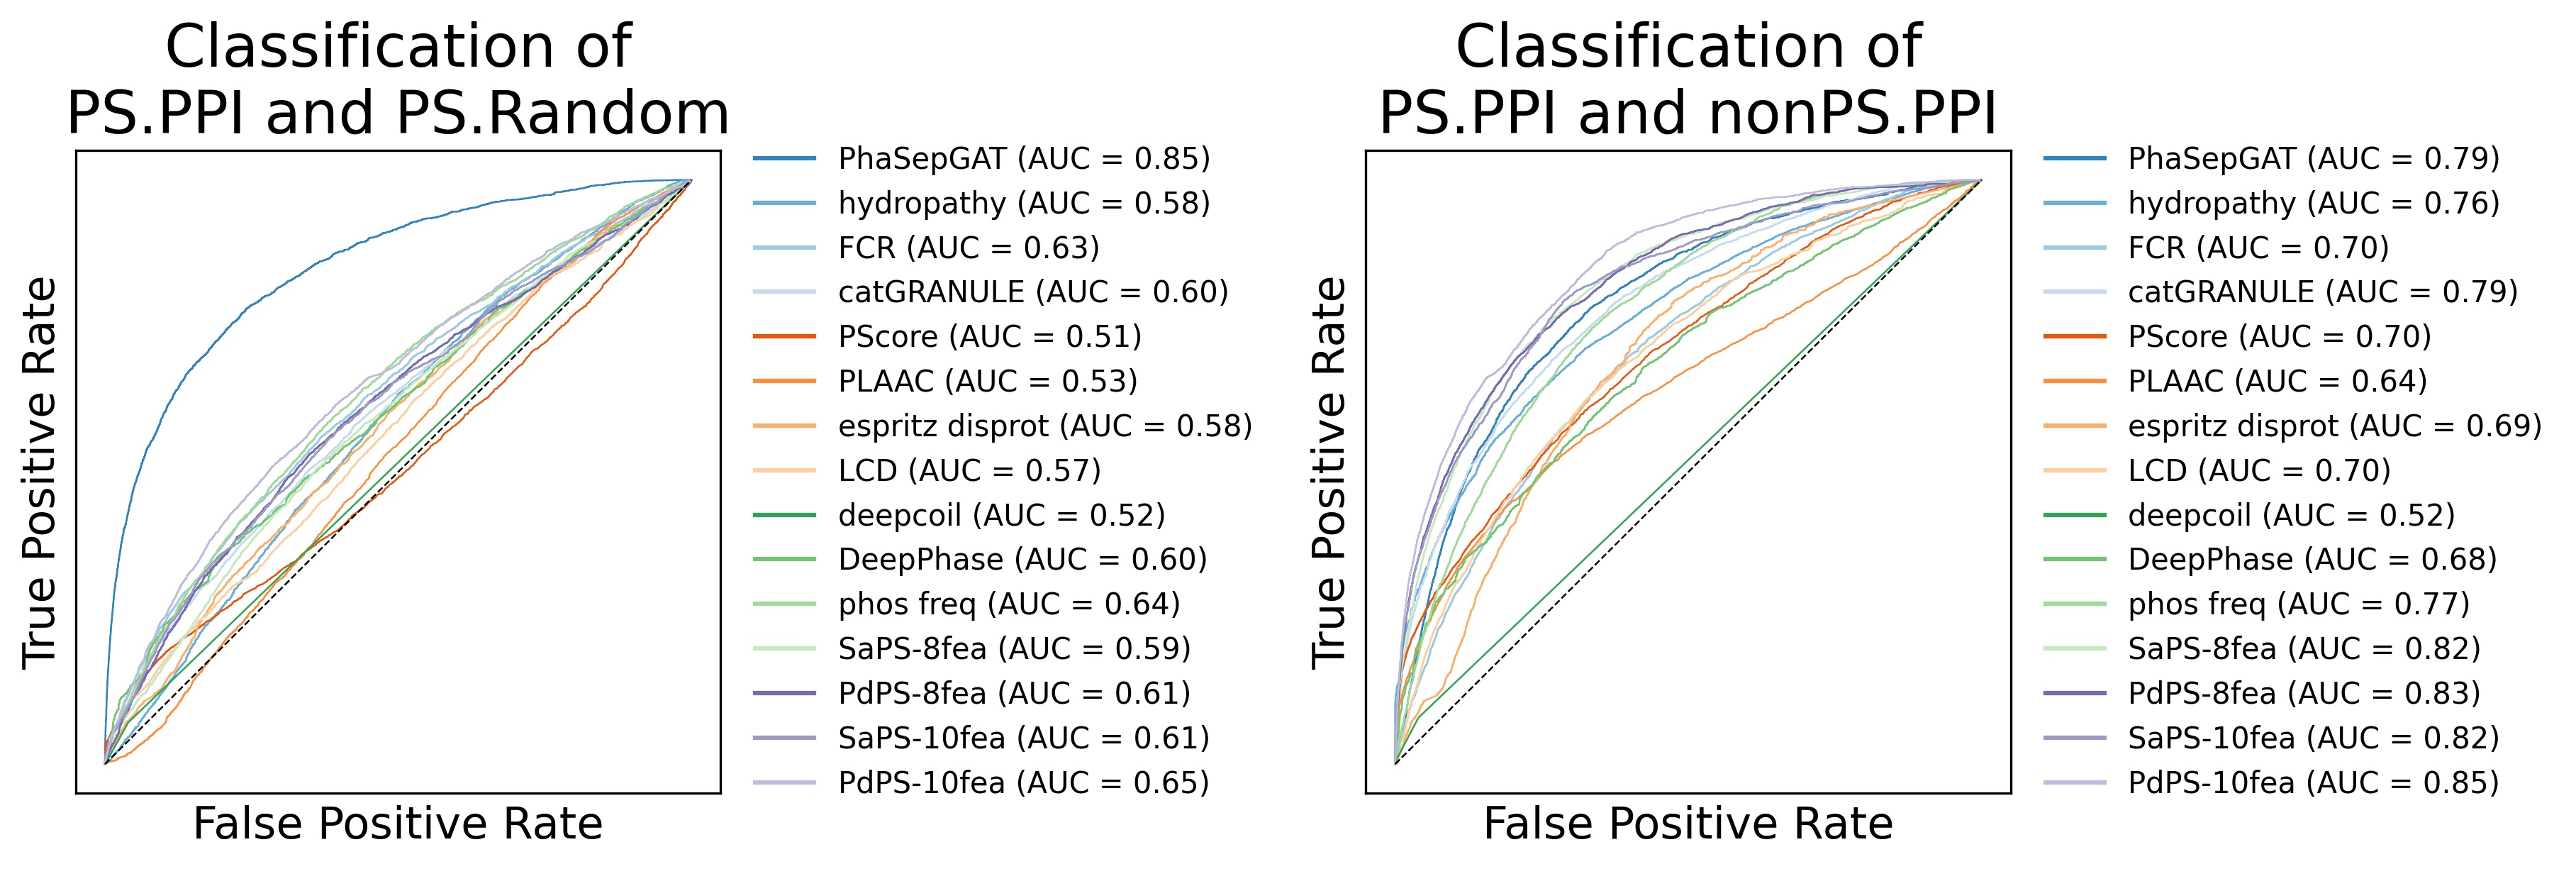

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    figsize=(15, 4),
    ncols=4, nrows=1,
    gridspec_kw={
        # 'height_ratios': [5, 1], 
        'width_ratios': [3, 2, 3, 2]
    }
)

ALPHA = 1
LW = .6
colors = plt.get_cmap('tab20c').colors

for item, color in zip(score_dict1.items(), colors):
    key, val = item
    fpr, tpr, auc_val = val['fpr'], val['tpr'], val['auc']
    ax1.plot(
        fpr, tpr,
        lw = LW,
        alpha = ALPHA,
        color = color,
        # label='{} AUC = {:.2f}'.format(key, auc_val)
    )

ax1.set_xlabel('False Positive Rate', fontsize=15)
ax1.set_ylabel('True Positive Rate', fontsize=15)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.plot([0, 1], [0, 1], 'k--', lw=LW)
# ax1.legend()
ax1.set_title('Classification of\nPS.PPI and PS.Random', size=20)

from matplotlib.lines import Line2D
handles = list()
for item, color in zip(score_dict1.items(), colors):
    key, val = item
    if key=='pred':
        key = 'PhaSepGAT'
    elif key=='IF':
        key = 'DeepPhase'
    patch = Line2D(
        [0], [0], 
        label='{} (AUC = {:.2f})'.format(key, val['auc']), 
        color=color
    )
    handles.append(patch)
ax2.legend(
    handles=handles,
    frameon=False,
    bbox_to_anchor = (1.05, 1.05)
)

for c in ['top', 'bottom', 'left', 'right']:
    ax2.spines[c].set_visible(None)
ax2.tick_params(bottom=False, left=False)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

for item, color in zip(score_dict2.items(), colors):
    key, val = item
    fpr, tpr, auc_val = val['fpr'], val['tpr'], val['auc']
    ax3.plot(
        fpr, tpr,
        lw = LW,
        alpha = ALPHA,
        color = color,
        # label='{} AUC = {:.2f}'.format(key, auc_val)
    )

ax3.set_xlabel('False Positive Rate', fontsize=15)
ax3.set_ylabel('True Positive Rate', fontsize=15)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.plot([0, 1], [0, 1], 'k--', lw=LW)
# ax3.legend()
ax3.set_title('Classification of\nPS.PPI and nonPS.PPI', size=20)

from matplotlib.lines import Line2D
handles = list()
for item, color in zip(score_dict2.items(), colors):
    key, val = item
    if key=='pred':
        key = 'PhaSepGAT'
    elif key=='IF':
        key = 'DeepPhase'
    patch = Line2D(
        [0], [0], 
        label='{} (AUC = {:.2f})'.format(key, val['auc']), 
        color=color
    )
    handles.append(patch)
ax4.legend(
    handles=handles,
    frameon=False,
    bbox_to_anchor = (1.05, 1.05)
)

for c in ['top', 'bottom', 'left', 'right']:
    ax4.spines[c].set_visible(None)
ax4.tick_params(bottom=False, left=False)
ax4.set_xlabel(None)
ax4.set_ylabel(None)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

### Box plot

In [27]:
dat = pd.read_pickle(f'{SAVE_ROOT}04-edge_classification.pkl')

In [28]:
dat.head()

,A,B,C,pred,type,hydropathy,FCR,catGRANULE,Pscore,PLAAC,espritz disprot,LCD,deepcoil,IF,phos freq,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea
0,Q9H2S6,Q9NPE6,Q9H2S6Q9NPE6,0.825629,nps.ppi,0.454167,0.241065,0.232927,1.915,-0.3215,0.070938,0.189570,0.0,NaN,0.003155,0.180668,0.333708,0.057492,0.202955
1,Q9H2S6,Q9BXK5,Q9BXK5Q9H2S6,0.779457,nps.ppi,0.459711,0.257904,-0.114610,1.000,-0.3765,0.006186,0.183050,0.0,NaN,0.029959,0.151175,0.245383,0.231277,0.328275
2,Q9H2S6,O60238,O60238Q9H2S6,0.482954,nps.ppi,0.434301,0.249968,0.436083,1.445,-0.2260,0.191781,0.219005,0.0,NaN,0.041967,0.349152,0.369417,0.475005,0.611476
3,Q9H2S6,P20138,P20138Q9H2S6,0.555613,nps.ppi,0.457043,0.229664,0.132726,1.000,-0.3420,0.057692,0.130096,0.0,NaN,0.015517,0.152326,0.247318,0.067165,0.205647
4,Q9H2S6,Q9UM44,Q9H2S6Q9UM44,0.402981,nps.ppi,0.461800,0.233374,0.032132,0.395,-0.3250,0.031401,0.098927,0.0,NaN,0.003155,0.149815,0.246193,0.058897,0.191480


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ps.ppi v.s. ps.rand: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=5.854e+08
ps.ppi v.s. nps.ppi: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=5.462e+08


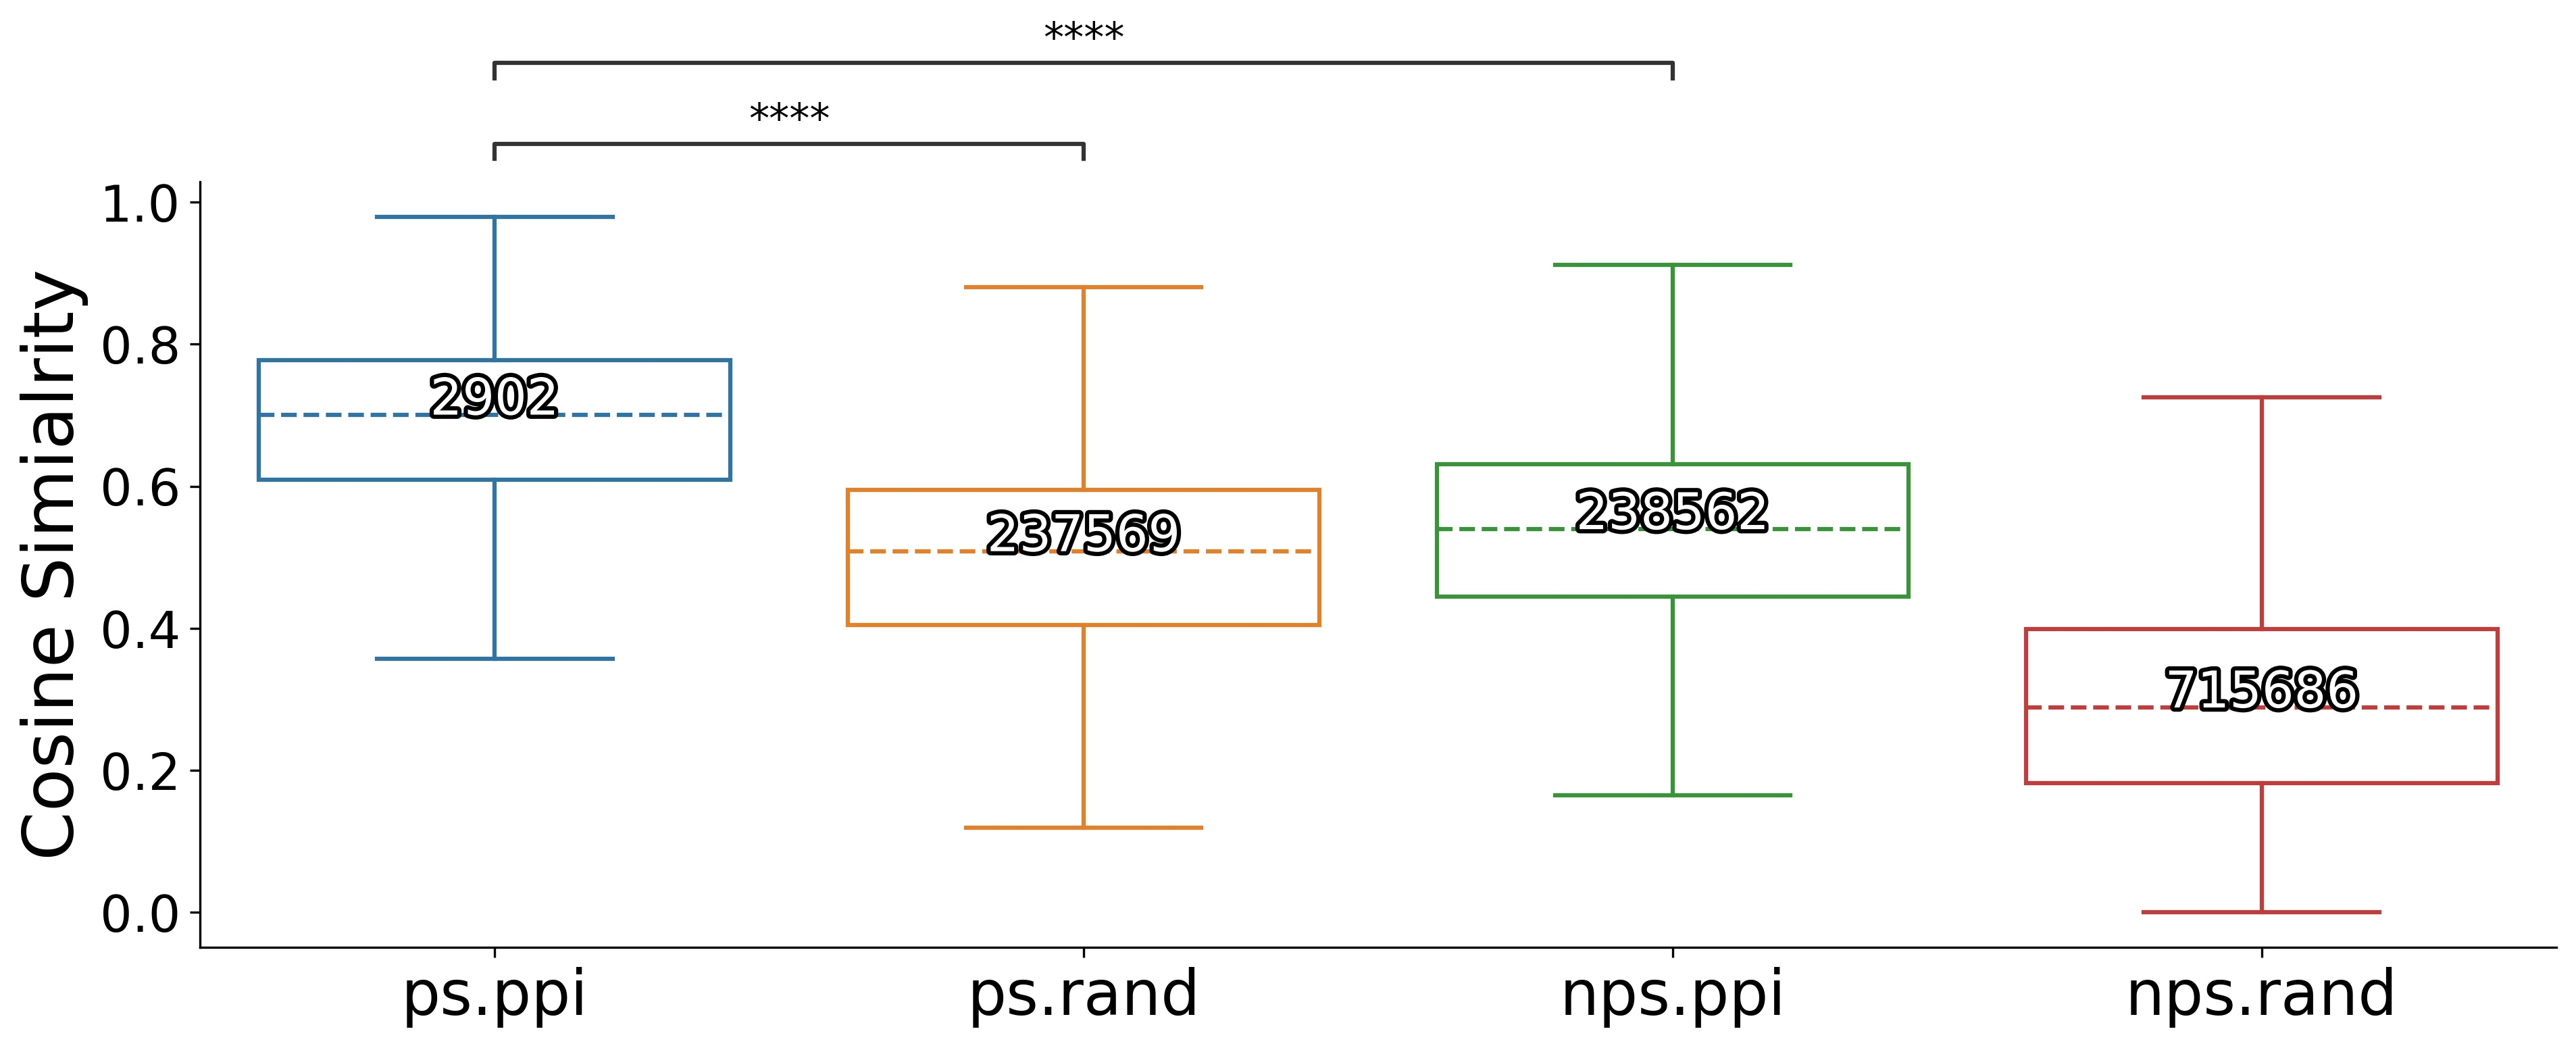

In [30]:
fig, ax = plt.subplots(
    figsize = (15, 5)
)
x, y = 'type', 'pred'
order = ['ps.ppi', 'ps.rand', 'nps.ppi', 'nps.rand']
PROPS = {
    # 'boxprops': {'facecolor': 'none'},
    'medianprops': {'linestyle':'--'}
}

sns.boxplot(
    x = x,
    y = y,
    data = dat,
    order = order,
    ax = ax,
    **PROPS,
    showfliers = False
)
ax.set_xlabel(None)
# ax.set_ylabel('Average Cosine Simialrity', size=25)
ax.set_ylabel('Cosine Simialrity', size=25)
ax.set_xticklabels(['ps.ppi', 'ps.rand', 'nps.ppi', 'nps.rand'], size=22)
ax.set_yticklabels([round(i, 2) for i in np.arange(-.2, 1.2, .2)], size=18)
ax.spines['top'].set_visible(None)
ax.spines['right'].set_visible(None)

from statannot import add_stat_annotation
add_stat_annotation(
    ax, x=x, y=y, data=dat,
    order=order,
    box_pairs=[
        ('ps.ppi', 'ps.rand'),
        ('ps.ppi', 'nps.ppi')
    ],
    test='Mann-Whitney', 
    comparisons_correction=None,
    text_format='star', 
    loc='outside', 
    verbose=2, 
    fontsize='x-large'
)

import matplotlib.colors as mc
import colorsys
def lighten_color(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

for i, artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = lighten_color(artist.get_facecolor(), 1)
    artist.set_edgecolor(col)
    artist.set_facecolor('white')
   
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*5,i*5+5):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        # line.set_linewidth(0.5)   # ADDITIONAL ADJUSTMENT
        
import matplotlib.patheffects as path_effects
text_size = 18
medians = dat.groupby([x])[y].median().to_frame().loc[order][y].values
nobs = dat[x].value_counts().to_frame().loc[order][x].values
nobs = [str(x) for x in nobs.tolist()]
pos = range(len(nobs))
for tick, label in zip(pos, ax.get_xticklabels()):
    text = ax.text(
        pos[tick],
        medians[tick],
        nobs[tick],
        horizontalalignment='center',
        size=text_size,
        color='w'
    )
    # create median-colored border around white text for contrast
    text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='k'),
        path_effects.Normal(),
    ])